In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import rasterio
from folium.raster_layers import ImageOverlay
import matplotlib.colors as mcolors
from IPython.display import IFrame
import plotly.express as px
import zipfile
import os
from folium import raster_layers
from io import BytesIO
from PIL import Image
import base64
from io import StringIO
import geopandas as gpd
from rasterio.plot import show
from rasterio.transform import rowcol
import seaborn as sns

In [2]:
tif_path = "/Users/maite/Downloads/4381f9078b2704eac4c9ab8c1631439c4ccff939.tif"
#https://www.frontiersin.org/journals/environmental-science/articles/10.3389/fenvs.2021.637455/full

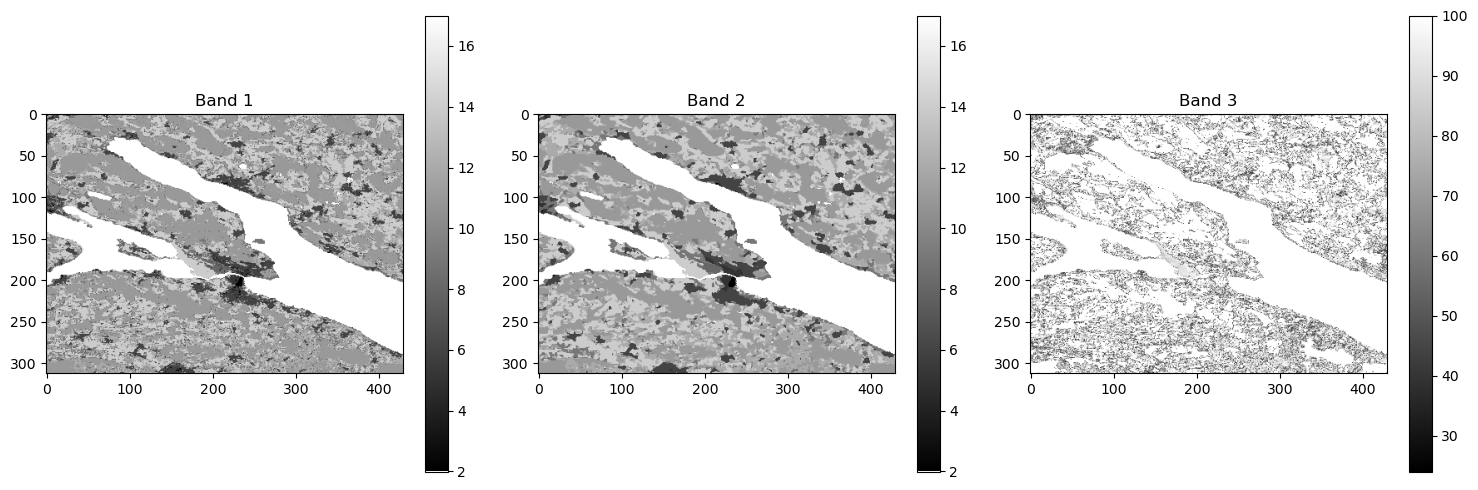

In [3]:
#was ist drin? 3 bands: “lcz” “lczFilter” and “classProbability”
with rasterio.open(tif_path) as dataset:
    
    bands = [dataset.read(i) for i in range(1, dataset.count + 1)]
    fig, axes = plt.subplots(1, dataset.count, figsize=(15, 5))
    for i, band in enumerate(bands):
        ax = axes[i]
        cax = ax.imshow(band, cmap='gray') 
        ax.set_title(f'Band {i+1}')
        fig.colorbar(cax, ax=ax, orientation='vertical')

    plt.tight_layout()
    plt.show()


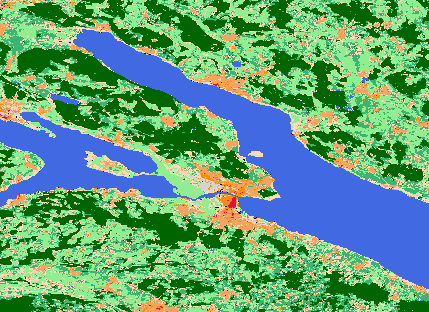

In [4]:
#erster blick lcz
with rasterio.open(tif_path) as src:
    band1 = src.read(1)
    bounds = src.bounds
    crs = src.crs
    transform = src.transform

map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
m = folium.Map(location=map_center, zoom_start=10, tiles='OpenStreetMap')

vmin, vmax = 1, 17
band1_normalized = np.uint8(255 * (band1 - vmin) / (vmax - vmin))  

colorscale = [
    [i / 16, color] 
    for i, color in enumerate([
        'darkred', 'crimson', 'red', 'sienna', 'darkorange', 'sandybrown',
        'yellow', 'lightgray', 'peachpuff', 'dimgray', 'darkgreen',
        'mediumseagreen', 'olivedrab', 'lightgreen', 'black', 'lemonchiffon', 'royalblue'
    ])
]

cmap = mcolors.ListedColormap([color for _, color in colorscale])

band1_colored = cmap(band1_normalized / 255.0) 
colored_image = (band1_colored[:, :, :3] * 255).astype(np.uint8)
img = Image.fromarray(colored_image)

buffer = BytesIO()
img.save(buffer, format='PNG')
buffer.seek(0)

img_base64 = base64.b64encode(buffer.getvalue()).decode()

raster_layer = raster_layers.ImageOverlay(
    image=f"data:image/png;base64,{img_base64}",
    bounds=[[bounds[1], bounds[0]], [bounds[3], bounds[2]]],
    opacity=0.6,
)
raster_layer.add_to(m)

m

In [5]:
#metagedöns einlesen
#koordinaten stationen
stationen = """name;Geogr.Laenge;Geogr.Breite
Döbele;9.16889836;47.65823856
Europapark;9.16282324;47.66721463
Fähre Staad;9.20933772;47.68211852
Friedrichstrasse;9.18375494;47.67557538
Herose-Park;9.17457428;47.66905485
Hörnle;9.21448949;47.66702444
Mainaustrasse;9.1877523;47.67050958
Marktstätte;9.17723865;47.6604731
Riedstrasse;9.14705786;47.6819759
Stadtgarten;9.17889136;47.66241869
Stephansplatz;9.17386062;47.66186644
Bodanplatz;9.174468;47.657871
"""
#von maja übernommen, bodanplatz ergänzt

stationen = StringIO(stationen)
stationen_meta = pd.read_csv(stationen, delimiter=";")
stationen_meta

,name,Geogr.Laenge,Geogr.Breite
0,Döbele,9.168898,47.658239
1,Europapark,9.162823,47.667215
2,Fähre Staad,9.209338,47.682119
3,Friedrichstrasse,9.183755,47.675575
4,Herose-Park,9.174574,47.669055
5,Hörnle,9.214489,47.667024
6,Mainaustrasse,9.187752,47.670510
7,Marktstätte,9.177239,47.660473
8,Riedstrasse,9.147058,47.681976
9,Stadtgarten,9.178891,47.662419


In [6]:
lcz = """LCZ_Class;description
1;compact highrise
2;compact midrise
3;compact lowrise
4;open highrise
5;open midrise
6;open lowrise
7;lightwieght lowrise
8;large lowrise
9;sparsely built
10;heavy industry
11;dense trees
12;scattered trees
13;bush, scrub
14;low plants
15;bare rock or paved
16;bare soil or sand
17;water
"""

lcz = StringIO(lcz)
lcz_meta = pd.read_csv(lcz, delimiter=";")
lcz_meta

,LCZ_Class,description
0,1,compact highrise
1,2,compact midrise
2,3,compact lowrise
3,4,open highrise
4,5,open midrise
5,6,open lowrise
6,7,lightwieght lowrise
7,8,large lowrise
8,9,sparsely built
9,10,heavy industry


In [7]:
#code von richard
#lcz werte für stationen abrufen
raster = rasterio.open(tif_path)
named_coordinates = list(zip(stationen_meta["name"],stationen_meta["Geogr.Laenge"], stationen_meta["Geogr.Breite"]))

# Koordinaten nutzen um Local Climate Zone Werte aus Raster zu extrahieren
results = []
for name,breite,länge in named_coordinates:
    # Koordinaten in Pixel (Zeile, Spalte) im Raster umwandeln
    row, col = row, col = rowcol(raster.transform, breite, länge)#rowcol(raster.transform, breite, länge)
    
    # LCZ-Wert an dieser Position auslesen
    lcz_value = raster.read(1)[row, col]
    # Ergebnis mit Namen speichern
    results.append({"name": name, "Geografische Länge": breite, "Geografische Breite": länge, "LCZ_Class": lcz_value})

lcz = pd.DataFrame(results)
lcz #falschrum (länge wird zu breite und breite zu länge)- klären why, schneller fix: varnamen getauscht

,name,Geografische Länge,Geografische Breite,LCZ_Class
0,Döbele,9.168898,47.658239,15
1,Europapark,9.162823,47.667215,9
2,Fähre Staad,9.209338,47.682119,5
3,Friedrichstrasse,9.183755,47.675575,5
4,Herose-Park,9.174574,47.669055,9
5,Hörnle,9.214489,47.667024,9
6,Mainaustrasse,9.187752,47.670510,9
7,Marktstätte,9.177239,47.660473,8
8,Riedstrasse,9.147058,47.681976,8
9,Stadtgarten,9.178891,47.662419,9


In [8]:
#mergen
lcz_stationen = pd.merge(lcz, lcz_meta, on="LCZ_Class", how="left")
lcz_stationen #keine wirkliche grünfläche, insg. nur 5 klassen

,name,Geografische Länge,Geografische Breite,LCZ_Class,description
0,Döbele,9.168898,47.658239,15,bare rock or paved
1,Europapark,9.162823,47.667215,9,sparsely built
2,Fähre Staad,9.209338,47.682119,5,open midrise
3,Friedrichstrasse,9.183755,47.675575,5,open midrise
4,Herose-Park,9.174574,47.669055,9,sparsely built
5,Hörnle,9.214489,47.667024,9,sparsely built
6,Mainaustrasse,9.187752,47.670510,9,sparsely built
7,Marktstätte,9.177239,47.660473,8,large lowrise
8,Riedstrasse,9.147058,47.681976,8,large lowrise
9,Stadtgarten,9.178891,47.662419,9,sparsely built


In [9]:
#wetterstationsdf einlesen
ws_compl_summer = pd.read_csv('/Users/maite/Downloads/ws_compl_summer.csv')

In [10]:
#interpolation
def linear_interpolation(df, column):
    #station für station durchgehen
    for station, group in df.groupby('name'):
        #fehlende Werte nur in der gruppe (station) auffüllen -> linear
        df.loc[group.index, column] = group[column].interpolate(method='linear', limit_direction='both')

    return df

ws_compl_summer_li = linear_interpolation(ws_compl_summer, 'temperature')
ws_compl_summer_li = ws_compl_summer_li[['name', 'date', 'hour', 'temperature']]
ws_compl_summer_li

,name,date,hour,temperature
0,Bodanplatz,2024-04-11,0,10.70
1,Bodanplatz,2024-04-11,1,10.70
2,Bodanplatz,2024-04-11,2,10.70
3,Bodanplatz,2024-04-11,3,10.70
4,Bodanplatz,2024-04-11,4,10.70
...,...,...,...,...
41179,Stephansplatz,2024-09-13,19,9.65
41180,Stephansplatz,2024-09-13,20,9.45
41181,Stephansplatz,2024-09-13,21,9.55
41182,Stephansplatz,2024-09-13,22,9.40


In [11]:
#merge mit meta informationen zu lcz
ws_compl_summer_li
data = pd.merge(ws_compl_summer_li, lcz_stationen, on="name", how="left")
data

,name,date,hour,temperature,Geografische Länge,Geografische Breite,LCZ_Class,description
0,Bodanplatz,2024-04-11,0,10.70,9.174468,47.657871,2,compact midrise
1,Bodanplatz,2024-04-11,1,10.70,9.174468,47.657871,2,compact midrise
2,Bodanplatz,2024-04-11,2,10.70,9.174468,47.657871,2,compact midrise
3,Bodanplatz,2024-04-11,3,10.70,9.174468,47.657871,2,compact midrise
4,Bodanplatz,2024-04-11,4,10.70,9.174468,47.657871,2,compact midrise
...,...,...,...,...,...,...,...,...
41179,Stephansplatz,2024-09-13,19,9.65,9.173861,47.661866,2,compact midrise
41180,Stephansplatz,2024-09-13,20,9.45,9.173861,47.661866,2,compact midrise
41181,Stephansplatz,2024-09-13,21,9.55,9.173861,47.661866,2,compact midrise
41182,Stephansplatz,2024-09-13,22,9.40,9.173861,47.661866,2,compact midrise


In [12]:
#check
missing_description_rows = data[data['description'].isna()]
missing_description_rows

,name,date,hour,temperature,Geografische Länge,Geografische Breite,LCZ_Class,description


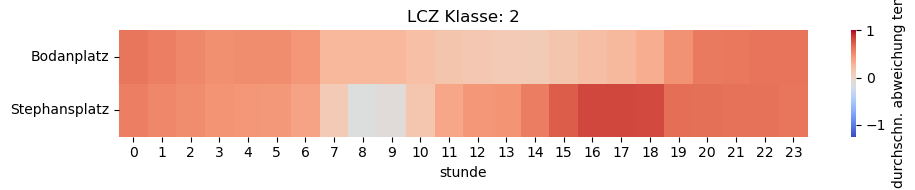

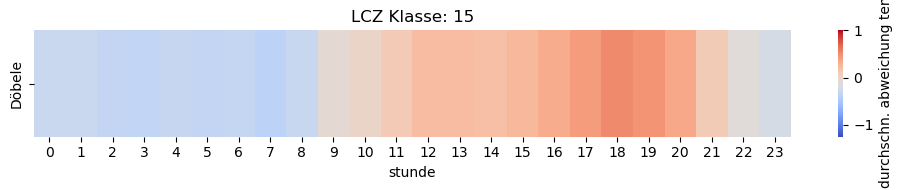

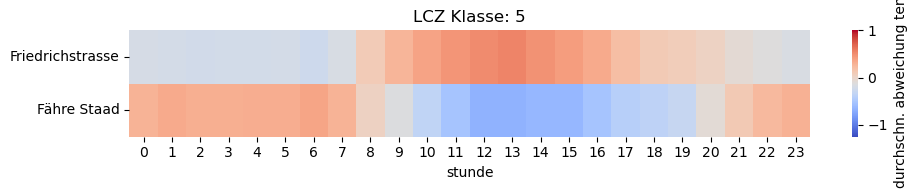

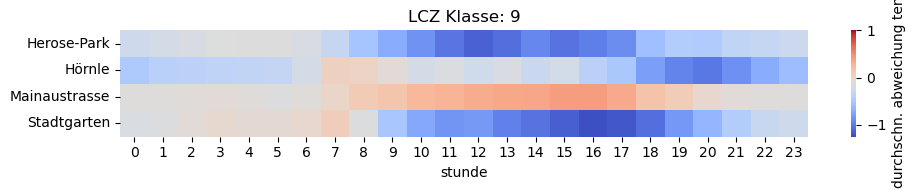

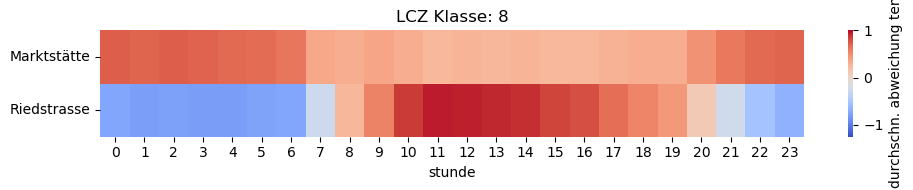

In [16]:
#selbe heatmap erstellen die ich schon mal gebastelt hab (abweichung vom stündlichen mean über alle stationen)
#aber jetzt unterteilt nach lcz, um zu checken ob tatsächlich ähnliche muster da sind

max_temp = 1
min_temp = -1.25

mean_temperatures = data.groupby(['hour', 'name'])['temperature'].mean().reset_index()
global_mean = data.groupby(['hour'])['temperature'].mean().reset_index()
global_mean = global_mean.rename(columns={'temperature': 'mean_temperature'})

heatmap = pd.merge(mean_temperatures, global_mean, on='hour')
heatmap['temperature_deviation'] = heatmap['temperature'] - heatmap['mean_temperature']

lcz_classes = data['LCZ_Class'].unique()

for lcz_class in lcz_classes: 
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 2))
    
    lcz_data = data[data['LCZ_Class'] == lcz_class]

    lcz_heatmap = heatmap[heatmap['name'].isin(lcz_data['name'])]
    lcz_heatmap_pivot = lcz_heatmap.pivot_table(index='name', columns='hour', values='temperature_deviation')

    sns.heatmap(lcz_heatmap_pivot, cmap='coolwarm', annot=False, fmt='.2f', 
                cbar_kws={'label': 'durchschn. abweichung temp.'}, vmin=min_temp, vmax=max_temp, ax=ax)

    ax.set_title(f'LCZ Klasse: {lcz_class}')
    ax.set_xlabel('stunde')
    ax.set_ylabel('')
    plt.tight_layout()
    plt.show()


In [14]:
#nicht wirklich die selben erwärmungsmuster 
#marktstätte bspw wär sehr viel ähnlicher an bodanplatz, ist aber in einer lcz mit riedstraße (industriegebiet)
#herosepark und mainaustraße & friedrichsstraße und staad clashen auch 

#grünflächen: herose, hörnle, stadtgarten nicht als grünflächen erkannt 
#idee: radius mit enthaltenen klimazonen?